<a href="https://colab.research.google.com/github/sykrabadi/Tugas-Akhir-Kecerdasan-Buatan/blob/main/Tugas_Akhir_Kecerdasan_Buatan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

Dataset : https://www.kaggle.com/luisblanche/covidct

Code :
1. https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM
2. https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py#L104
3. https://github.com/zhixuhao/unet
4. https://www.kaggle.com/alexandralorenzo/simple-cnn-model-on-covid-19-images
5. https://github.com/deadskull7/One-Stop-for-COVID-19-Infection-and-Lung-Segmentation-plus-Classification/blob/master/Notebooks/task3_lung_segmentation_unet.ipynb

Papers :
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7451075/
2. https://www.mdpi.com/1660-4601/16/2/250
3. https://www.nature.com/articles/s41467-020-20657-4
4. https://www.spiedigitallibrary.org/journals/journal-of-medical-imaging/volume-8/issue-S1/014502/Deep-CNN-models-for-predicting-COVID-19-in-CT-and/10.1117/1.JMI.8.S1.014502.full?SSO=1
5. https://www.sciencedirect.com/science/article/pii/S1877050918301157
6. https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

# Import libraries

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 30.5 MB/s 


In [ ]:
import glob
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
from keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import xlsxwriter
%matplotlib inline

# Mount to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load image path

In [ ]:
root = '/content/drive/MyDrive/Dataset'
positive_case = os.path.join(root, 'CT_COVID')
negative_case = os.path.join(root, 'CT_NonCOVID')

In [ ]:
print(positive_case)
print(negative_case)

/content/drive/MyDrive/Dataset/CT_COVID
/content/drive/MyDrive/Dataset/CT_NonCOVID


# Load image data

In [ ]:
positive_case_img = glob.glob(os.path.join(positive_case, "*.png"))
negative_case_img = glob.glob(os.path.join(negative_case, "*.png"))
negative_case_img.extend(glob.glob(os.path.join(negative_case, "*.jpg")))

In [ ]:
total_positive_case = len(positive_case_img)
total_negative_case = len(negative_case_img)
print(f"Total positive case: {total_positive_case}")
print(f"Total negative case: {total_negative_case}")

Total positive case: 349
Total negative case: 397


(202, 287, 3)
(356, 512, 3)


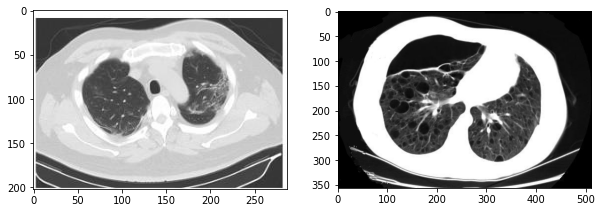

In [ ]:
positive_img = cv2.imread(positive_case_img[0])
negative_img = cv2.imread(negative_case_img[0])

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.imshow(positive_img)
fig.add_subplot(1,2,2)
plt.imshow(negative_img)

print(positive_img.shape)
print(negative_img.shape)

# Create Train/Test directory

In [ ]:
covid = {
    'class': 'CT_COVID',
    'path': positive_case,
    'images': positive_case_img
}

non_covid= {
    'class': 'CT_NonCOVID',
    'path': negative_case,
    'images': negative_case_img
}

In [ ]:
subdirs = ['/train', '/test']
for subdir in subdirs:
  label_dirs = ['/CT_COVID', '/CT_NonCOVID']
  for label in label_dirs:
    new_dir = root + subdir + label
    os.makedirs(new_dir, exist_ok=True)

In [ ]:
test_dir = root + '/test'
train_dir = root + '/train'

In [ ]:
# Create test image directory
random.seed(42)

test_split = 0.2

for cases in [covid, non_covid]:
  tota_img = len(cases['images'])
  total_img_selected = int(tota_img * test_split)

  print(cases['class'], total_img_selected)

  random_selected_img = random.sample(cases['images'], total_img_selected)

  for images in random_selected_img:
    shutil.copy2(images, test_dir + '/' + cases['class'])

In [ ]:
# Create train image director
for cases in [covid, non_covid]:
  test_images = os.listdir(test_dir + '/' + cases['class'])
  for images in cases['images']:
    if images.split('/')[-1] not in (test_images):
      shutil.copy2(images, train_dir + '/' + cases['class'])

In [ ]:
# verify that sum of the total test and train images are equal to total of whole dataset

total_test_covid = len(os.listdir(test_dir + '/CT_COVID'))
total_test_noncovid = len(os.listdir(test_dir + '/CT_NonCOVID'))
total_train_covid = len(os.listdir(train_dir + '/CT_COVID'))
total_train_noncovid = len(os.listdir(train_dir + '/CT_NonCOVID'))
print(total_train_covid)
print(total_train_noncovid)
print(total_test_covid)
print(total_test_noncovid)

# Data preparation

In [ ]:
test_dir = root + '/test'
train_dir = root + '/train'
total_test_covid = len(os.listdir(test_dir + '/CT_COVID'))
total_test_noncovid = len(os.listdir(test_dir + '/CT_NonCOVID'))
total_train_covid = len(os.listdir(train_dir + '/CT_COVID'))
total_train_noncovid = len(os.listdir(train_dir + '/CT_NonCOVID'))

In [ ]:
total_train_data = total_train_covid + total_train_noncovid
total_test_data = total_test_covid + total_test_noncovid
IMG_HEIGHT = 128
IMG_WIDTH = 128
batch_size = 128
train_batch_size = int(total_train_data * 0.8)

train_dir = os.path.join(root + '/train')
test_dir = os.path.join(root + '/test')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    subset="training",
    color_mode='rgb',
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size=train_batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    seed=42,
    subset="validation",
    color_mode='rgb',
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)

Found 598 files belonging to 2 classes.
Using 479 files for training.
Found 148 files belonging to 2 classes.
Using 29 files for validation.
['CT_COVID', 'CT_NonCOVID']


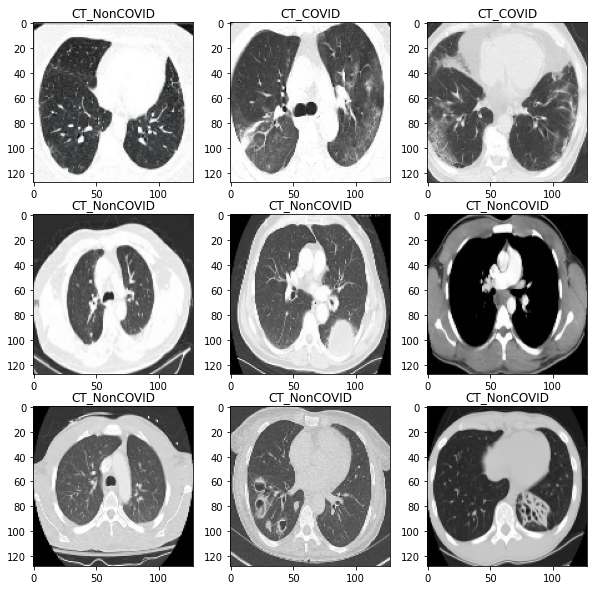

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [ ]:
for image_batch, labels_batch in train_ds:
  image_arr = image_batch.numpy()
  label_arr = labels_batch.numpy()
  break

for test_image_batch, test_labels_batch in test_ds:
  test_image_arr = test_image_batch.numpy()
  test_label_arr = test_labels_batch.numpy()
  break

from tensorflow.keras.utils import to_categorical
categorical_arr, test_categorical_arr = to_categorical(label_arr), to_categorical(test_label_arr)
img_input, test_img_input = np.array([img.flatten() for img in image_arr]), np.array([img.flatten() for img in test_image_arr])
img_input, test_img_input = np.array([x/255 for x in img_input]), np.array([x/255 for x in test_img_input])
print(f"Before flattening train image {image_arr.shape}, after flattening train image {img_input.shape}")
print(f"Before flattening test image {test_image_arr.shape}, after flattening test image {test_img_input.shape}")

Before flattening train image (478, 128, 128, 3), after flattening train image (478, 49152)
Before flattening test image (29, 128, 128, 3), after flattening test image (29, 49152)


# Manual model definition

In [ ]:
# ignore exp warning raises by np.exp() function
import warnings
warnings.filterwarnings('ignore')

## Train against train data

In [ ]:
input = img_input
target = categorical_arr

np.random.seed(42)

# both num_input and num_output are accessing the second tuple value, which
# corrensponds to the number of array values
num_input = input.shape[1]
num_output = target.shape[1]
hidden = 30

# print(num_input)
# print(num_output)

# hidden layer
w_hidden = np.random.uniform(low=-2, high=2, size=(num_input, hidden))
b_hidden = np.random.uniform(low=-2, high=2, size=(hidden))

# output layer
w_output = np.random.uniform(low=-2, high=2, size=(hidden, num_output))
b_output = np.random.uniform(low=-2, high=2, size=(num_output))
const_w_hidden = w_hidden
const_b_hidden = b_hidden
const_w_output = w_output
const_b_output = b_output

# learning rate dan epoch
epochs = 5
lr = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
momentum = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
lr_and_momentum = zip(lr, momentum)
result = []

for i in range(7):
  # loss dan accuracy
  loss = []
  accuracy = []
  print(f"Result for learning rate {lr[i]} and momentum {momentum[i]}")
  for epoch in range(epochs):
    MSE = 0
    new_target = np.zeros(target.shape)

    delta_w_output_prev = []
    delta_w_hidden_prev = []
    delta_b_output_prev = []
    delta_b_hidden_prev = []

    for idx, val in enumerate(input):

      # feedforward
      output_hidden = np.matmul(input[idx], w_hidden) + b_hidden
      output_hidden = 1 / (1 + np.exp(-output_hidden))

      output_result = np.matmul(output_hidden, w_output) + b_output
      output_result = 1 / (1 + np.exp(-output_result))

      error = target[idx] - output_result
      MSE = MSE + (np.sum(error*error)/error.shape)
      new_target[idx] = output_result.round()

      error_hidden = error @ w_output.T

      # backpropagation
      delta_w_output = (lr[i] * ((error * output_result * (1 -  output_result)) * output_hidden[np.newaxis].T ))
      delta_w_hidden = (lr[i] * ((error_hidden * output_hidden * (1 - output_hidden)) * input[idx][np.newaxis].T))
      delta_b_output = (lr[i] * ((error * output_result * (1 -  output_result))))
      delta_b_hidden = (lr[i] * (error_hidden * output_hidden * (1 - output_hidden)))

      delta_w_output_prev.append(delta_w_output)
      delta_w_hidden_prev.append(delta_w_hidden)
      delta_b_output_prev.append(delta_b_output)
      delta_b_hidden_prev.append(delta_b_hidden)
      
      if epoch == 0:
        w_hidden = const_w_hidden
        b_hidden = const_b_hidden
        w_output = const_w_output
        b_output = const_b_output

        w_output = w_output + delta_w_output
        b_output = b_output + delta_b_output

        w_hidden = w_hidden + delta_w_hidden
        b_hidden = b_hidden + delta_b_hidden

      else:
        w_output = w_output + delta_w_output + (momentum[i] * delta_w_output_prev[idx - 1])
        b_output = b_output + delta_b_output + (momentum[i] * delta_b_output_prev[idx - 1])

        w_hidden = w_hidden + delta_w_hidden + (momentum[i] * delta_w_hidden_prev[idx - 1])
        b_hidden = b_hidden + delta_b_hidden + (momentum[i] * delta_b_hidden_prev[idx - 1])

    MSE = MSE / input.shape[0]
    delta = np.absolute(target -  new_target)
    acc = 1 - np.average([np.max(m) for m in delta])
    result.append([MSE.astype(float), acc, lr[i], momentum[i]])
    loss.append(MSE.astype(float))
    accuracy.append(acc)
    print("=====================================================")
    print(f"Epoch : {epoch + 1} | MSE : {MSE} | Accuracy : {acc}")
    print("=====================================================")

Result for learning rate 0.5 and momentum 0.1
Epoch : 1 | MSE : [0.43638088] | Accuracy : 0.35564853556485354
Epoch : 2 | MSE : [0.31890852] | Accuracy : 0.4728033472803347
Epoch : 3 | MSE : [0.30229641] | Accuracy : 0.502092050209205
Epoch : 4 | MSE : [0.30192873] | Accuracy : 0.502092050209205
Epoch : 5 | MSE : [0.3017208] | Accuracy : 0.50418410041841
Result for learning rate 0.6 and momentum 0.2
Epoch : 1 | MSE : [0.43748347] | Accuracy : 0.35564853556485354
Epoch : 2 | MSE : [0.33104261] | Accuracy : 0.4728033472803347
Epoch : 3 | MSE : [0.31999009] | Accuracy : 0.5104602510460251
Epoch : 4 | MSE : [0.31930871] | Accuracy : 0.5125523012552301
Epoch : 5 | MSE : [0.31902947] | Accuracy : 0.5125523012552301
Result for learning rate 0.7 and momentum 0.3
Epoch : 1 | MSE : [0.43742754] | Accuracy : 0.35146443514644354
Epoch : 2 | MSE : [0.34187256] | Accuracy : 0.4623430962343096
Epoch : 3 | MSE : [0.31903173] | Accuracy : 0.5125523012552301
Epoch : 4 | MSE : [0.32226227] | Accuracy : 0

## Validate against test data

In [ ]:
input = test_img_input
target = test_categorical_arr

np.random.seed(42)

# both num_input and num_output are accessing the second tuple value, which
# corrensponds to the number of array values
num_input = input.shape[1]
num_output = target.shape[1]
hidden = 30

# print(num_input)
# print(num_output)

# hidden layer
w_hidden = np.random.uniform(low=-2, high=2, size=(num_input, hidden))
b_hidden = np.random.uniform(low=-2, high=2, size=(hidden))

# output layer
w_output = np.random.uniform(low=-2, high=2, size=(hidden, num_output))
b_output = np.random.uniform(low=-2, high=2, size=(num_output))
const_w_hidden = w_hidden
const_b_hidden = b_hidden
const_w_output = w_output
const_b_output = b_output
# loss dan accuracy
test_loss = []
test_accuracy = []

# learning rate dan epoch
epochs = 5
lr = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
momentum = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
lr_and_momentum = zip(lr, momentum)
test_result = []

for i in range(7):
  print(f"Result for leraning rate {lr[i]} and momentum {momentum[i]}")
  for epoch in range(epochs):
    MSE = 0
    new_target = np.zeros(target.shape)

    delta_w_output_prev = []
    delta_w_hidden_prev = []
    delta_b_output_prev = []
    delta_b_hidden_prev = []

    for idx, val in enumerate(input):

      # feedforward
      output_hidden = np.matmul(input[idx], w_hidden) + b_hidden
      output_hidden = 1 / (1 + np.exp(-output_hidden))

      output_result = np.matmul(output_hidden, w_output) + b_output
      output_result = 1 / (1 + np.exp(-output_result))

      error = target[idx] - output_result
      MSE = MSE + (np.sum(error*error)/error.shape)
      new_target[idx] = output_result.round()

      error_hidden = error @ w_output.T

      # backpropagation
      delta_w_output = (lr[i] * ((error * output_result * (1 -  output_result)) * output_hidden[np.newaxis].T ))
      delta_w_hidden = (lr[i] * ((error_hidden * output_hidden * (1 - output_hidden)) * input[idx][np.newaxis].T))
      delta_b_output = (lr[i] * ((error * output_result * (1 -  output_result))))
      delta_b_hidden = (lr[i] * (error_hidden * output_hidden * (1 - output_hidden)))

      delta_w_output_prev.append(delta_w_output)
      delta_w_hidden_prev.append(delta_w_hidden)
      delta_b_output_prev.append(delta_b_output)
      delta_b_hidden_prev.append(delta_b_hidden)
      
      if epoch == 0:
        w_hidden = const_w_hidden
        b_hidden = const_b_hidden
        w_output = const_w_output
        b_output = const_b_output

        w_output = w_output + delta_w_output
        b_output = b_output + delta_b_output

        w_hidden = w_hidden + delta_w_hidden
        b_hidden = b_hidden + delta_b_hidden

      else:
        w_output = w_output + delta_w_output + (momentum[i] * delta_w_output_prev[idx - 1])
        b_output = b_output + delta_b_output + (momentum[i] * delta_b_output_prev[idx - 1])

        w_hidden = w_hidden + delta_w_hidden + (momentum[i] * delta_w_hidden_prev[idx - 1])
        b_hidden = b_hidden + delta_b_hidden + (momentum[i] * delta_b_hidden_prev[idx - 1])

    MSE = MSE / input.shape[0]
    delta = np.absolute(target -  new_target)
    acc = 1 - np.average([np.max(m) for m in delta])
    test_result.append([MSE.astype(float), acc, lr[i], momentum[i]])
    test_loss.append(MSE.astype(float))
    test_accuracy.append(acc)
    print("=====================================================")
    print(f"Epoch : {epoch + 1} | MSE : {MSE} | Accuracy : {acc}")
    print("=====================================================")

Result for leraning rate 0.5 and momentum 0.1
Epoch : 1 | MSE : [0.51746511] | Accuracy : 0.2068965517241379
Epoch : 2 | MSE : [0.48368209] | Accuracy : 0.13793103448275867
Epoch : 3 | MSE : [0.32759519] | Accuracy : 0.5172413793103448
Epoch : 4 | MSE : [0.29096538] | Accuracy : 0.48275862068965514
Epoch : 5 | MSE : [0.28438555] | Accuracy : 0.48275862068965514
Result for leraning rate 0.6 and momentum 0.2
Epoch : 1 | MSE : [0.48423314] | Accuracy : 0.24137931034482762
Epoch : 2 | MSE : [0.48278378] | Accuracy : 0.1724137931034483
Epoch : 3 | MSE : [0.32972481] | Accuracy : 0.48275862068965514
Epoch : 4 | MSE : [0.30782431] | Accuracy : 0.4482758620689655
Epoch : 5 | MSE : [0.28917062] | Accuracy : 0.5517241379310345
Result for leraning rate 0.7 and momentum 0.3
Epoch : 1 | MSE : [0.48231115] | Accuracy : 0.27586206896551724
Epoch : 2 | MSE : [0.4611498] | Accuracy : 0.1724137931034483
Epoch : 3 | MSE : [0.34762356] | Accuracy : 0.5862068965517242
Epoch : 4 | MSE : [0.33429162] | Accur

# View Report

## View report for validation data

Text(0.5, 1.0, 'Validataion Loss')

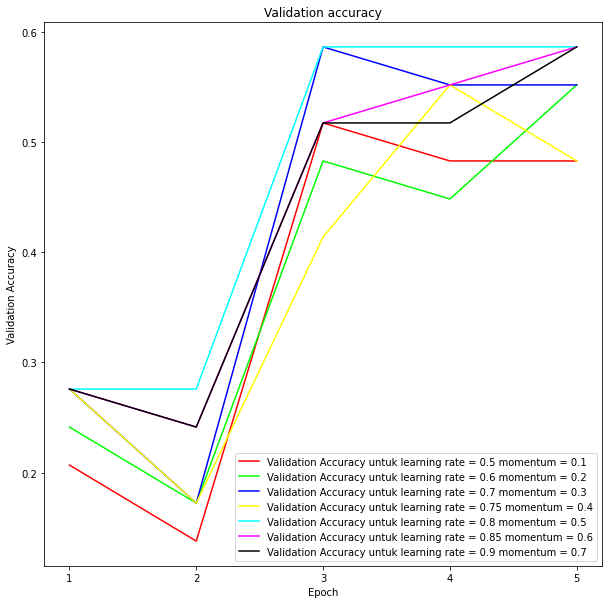

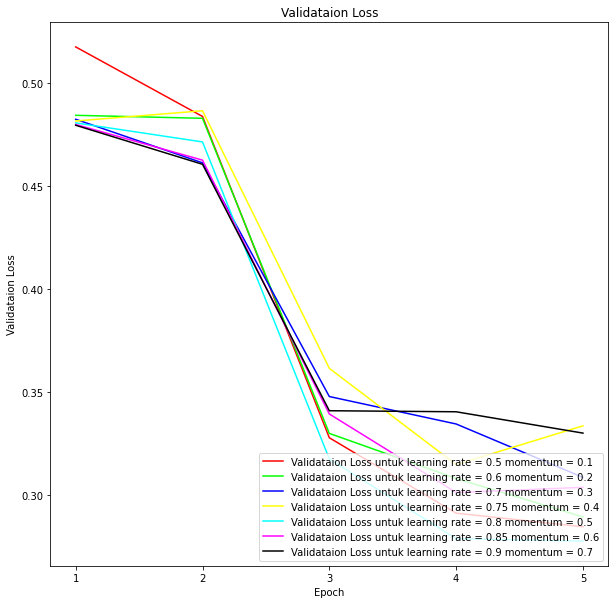

In [ ]:
import matplotlib.pyplot as plt
acc = test_accuracy
loss = test_loss
epochs_range = np.arange(1, epochs + 1)

result_1 = test_result[:5]
result_2 = test_result[5:10]
result_3 = test_result[10:15]
result_4 = test_result[15:20]
result_5 = test_result[20:25]
result_6 = test_result[25:30]
result_7 = test_result[30:35]

MSE_1, acc_1 = [], []
MSE_2, acc_2 = [], []
MSE_3, acc_3 = [], []
MSE_4, acc_4 = [], []
MSE_5, acc_5 = [], []
MSE_6, acc_6 = [], []
MSE_7, acc_7 = [], []

for i in result_1:
  MSE_1.append(i[0])
  acc_1.append(i[1])

for i in result_2:
  MSE_2.append(i[0])
  acc_2.append(i[1])

for i in result_3:
  MSE_3.append(i[0])
  acc_3.append(i[1])

for i in result_4:
  MSE_4.append(i[0])
  acc_4.append(i[1])

for i in result_5:
  MSE_5.append(i[0])
  acc_5.append(i[1])

for i in result_6:
  MSE_6.append(i[0])
  acc_6.append(i[1])

for i in result_7:
  MSE_7.append(i[0])
  acc_7.append(i[1])

lr = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
momentum = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Accuracy")
ax.plot(epochs_range, acc_1, label=f'Validation Accuracy untuk learning rate = {lr[0]} momentum = {momentum[0]}', color="#FF0000")
ax.plot(epochs_range, acc_2, label=f'Validation Accuracy untuk learning rate = {lr[1]} momentum = {momentum[1]}', color="#00FF00")
ax.plot(epochs_range, acc_3, label=f'Validation Accuracy untuk learning rate = {lr[2]} momentum = {momentum[2]}', color="#0000FF")
ax.plot(epochs_range, acc_4, label=f'Validation Accuracy untuk learning rate = {lr[3]} momentum = {momentum[3]}', color="#FFFF00")
ax.plot(epochs_range, acc_5, label=f'Validation Accuracy untuk learning rate = {lr[4]} momentum = {momentum[4]}', color="#00FFFF")
ax.plot(epochs_range, acc_6, label=f'Validation Accuracy untuk learning rate = {lr[5]} momentum = {momentum[5]}', color="#FF00FF")
ax.plot(epochs_range, acc_7, label=f'Validation Accuracy untuk learning rate = {lr[6]} momentum = {momentum[6]}', color="#000000")
ax.legend(loc='lower right')
ax.set_xticks(epochs_range)
ax.set_title(f"Validation accuracy")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Epoch")
ax.set_ylabel("Validataion Loss")
ax.plot(epochs_range, MSE_1, label=f'Validataion Loss untuk learning rate = {lr[0]} momentum = {momentum[0]}', color="#FF0000")
ax.plot(epochs_range, MSE_2, label=f'Validataion Loss untuk learning rate = {lr[1]} momentum = {momentum[1]}', color="#00FF00")
ax.plot(epochs_range, MSE_3, label=f'Validataion Loss untuk learning rate = {lr[2]} momentum = {momentum[2]}', color="#0000FF")
ax.plot(epochs_range, MSE_4, label=f'Validataion Loss untuk learning rate = {lr[3]} momentum = {momentum[3]}', color="#FFFF00")
ax.plot(epochs_range, MSE_5, label=f'Validataion Loss untuk learning rate = {lr[4]} momentum = {momentum[4]}', color="#00FFFF")
ax.plot(epochs_range, MSE_6, label=f'Validataion Loss untuk learning rate = {lr[5]} momentum = {momentum[5]}', color="#FF00FF")
ax.plot(epochs_range, MSE_7, label=f'Validataion Loss untuk learning rate = {lr[6]} momentum = {momentum[6]}', color="#000000")
ax.legend(loc='lower right')
ax.set_xticks(epochs_range)
ax.set_title(f"Validataion Loss")

## View report for train data

Text(0.5, 1.0, 'Training Loss')

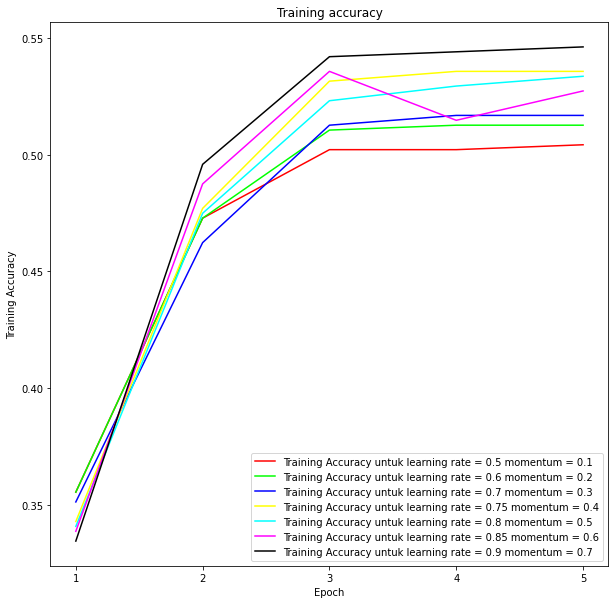

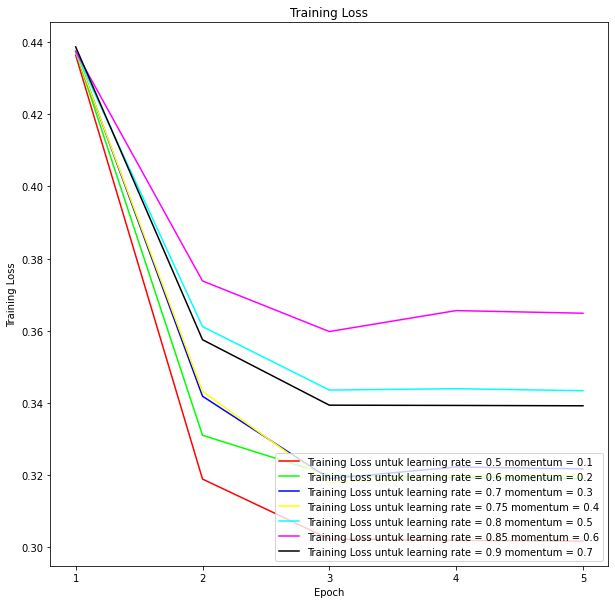

In [ ]:
import matplotlib.pyplot as plt
acc = accuracy
loss = loss
epochs_range = np.arange(1, epochs + 1)

result_1 = result[:5]
result_2 = result[5:10]
result_3 = result[10:15]
result_4 = result[15:20]
result_5 = result[20:25]
result_6 = result[25:30]
result_7 = result[30:35]

MSE_1, acc_1 = [], []
MSE_2, acc_2 = [], []
MSE_3, acc_3 = [], []
MSE_4, acc_4 = [], []
MSE_5, acc_5 = [], []
MSE_6, acc_6 = [], []
MSE_7, acc_7 = [], []

for i in result_1:
  MSE_1.append(i[0])
  acc_1.append(i[1])

for i in result_2:
  MSE_2.append(i[0])
  acc_2.append(i[1])

for i in result_3:
  MSE_3.append(i[0])
  acc_3.append(i[1])

for i in result_4:
  MSE_4.append(i[0])
  acc_4.append(i[1])

for i in result_5:
  MSE_5.append(i[0])
  acc_5.append(i[1])

for i in result_6:
  MSE_6.append(i[0])
  acc_6.append(i[1])

for i in result_7:
  MSE_7.append(i[0])
  acc_7.append(i[1])

lr = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
momentum = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Accuracy")
ax.plot(epochs_range, acc_1, label=f'Training Accuracy untuk learning rate = {lr[0]} momentum = {momentum[0]}', color="#FF0000")
ax.plot(epochs_range, acc_2, label=f'Training Accuracy untuk learning rate = {lr[1]} momentum = {momentum[1]}', color="#00FF00")
ax.plot(epochs_range, acc_3, label=f'Training Accuracy untuk learning rate = {lr[2]} momentum = {momentum[2]}', color="#0000FF")
ax.plot(epochs_range, acc_4, label=f'Training Accuracy untuk learning rate = {lr[3]} momentum = {momentum[3]}', color="#FFFF00")
ax.plot(epochs_range, acc_5, label=f'Training Accuracy untuk learning rate = {lr[4]} momentum = {momentum[4]}', color="#00FFFF")
ax.plot(epochs_range, acc_6, label=f'Training Accuracy untuk learning rate = {lr[5]} momentum = {momentum[5]}', color="#FF00FF")
ax.plot(epochs_range, acc_7, label=f'Training Accuracy untuk learning rate = {lr[6]} momentum = {momentum[6]}', color="#000000")
ax.legend(loc='lower right')
ax.set_xticks(epochs_range)
ax.set_title(f"Training accuracy")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.plot(epochs_range, MSE_1, label=f'Training Loss untuk learning rate = {lr[0]} momentum = {momentum[0]}', color="#FF0000")
ax.plot(epochs_range, MSE_2, label=f'Training Loss untuk learning rate = {lr[1]} momentum = {momentum[1]}', color="#00FF00")
ax.plot(epochs_range, MSE_3, label=f'Training Loss untuk learning rate = {lr[2]} momentum = {momentum[2]}', color="#0000FF")
ax.plot(epochs_range, MSE_4, label=f'Training Loss untuk learning rate = {lr[3]} momentum = {momentum[3]}', color="#FFFF00")
ax.plot(epochs_range, MSE_5, label=f'Training Loss untuk learning rate = {lr[4]} momentum = {momentum[4]}', color="#00FFFF")
ax.plot(epochs_range, MSE_6, label=f'Training Loss untuk learning rate = {lr[5]} momentum = {momentum[5]}', color="#FF00FF")
ax.plot(epochs_range, MSE_7, label=f'Training Loss untuk learning rate = {lr[6]} momentum = {momentum[6]}', color="#000000")
ax.legend(loc='lower right')
ax.set_xticks(epochs_range)
ax.set_title(f"Training Loss")